In [18]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from dl_toolbox.lightning_modules import *
from dl_toolbox.lightning_datamodules import *
from pathlib import Path, PurePath
from datetime import datetime
import os

In [19]:
preds_path = Path('/data/outputs/digitanie/arcachon/01Mar23-09h56m08/preds')
raster_path = Path('/data/DIGITANIE/Arcachon/Arcachon_EPSG32630_8.tif')

In [24]:
import rasterio
from rasterio import plot as rioplt

raster_file = rasterio.open(raster_path)
h,w = raster_file.shape


In [27]:
import glob
import numpy as np
preds = glob.glob(str(preds_path)+'/*.tif')
pred_full = np.zeros((6,h,w))
print(pred_full.shape)
for pred in preds:
    with rasterio.open(pred) as pred_f:
        img = pred_f.read()
    col_off, row_off = [int(a) for a in pred.split('.')[0].split('_')[-2:]]
    pred_full[:,row_off:row_off+256, col_off:col_off+256] += img

(6, 2048, 2048)


In [38]:
pred = np.argmax(pred_full, axis=0)

In [39]:
labels_dict = {
    
    '6mainFuseVege': {
        'nodata': {'color': (0, 0, 0)},
        'vegetation': {'color':(0, 250, 50)},
        'water': {'color':(0, 50, 250)},
        'building': {'color':(250, 50, 50)},
        'road': {'color':(100, 100, 100)},
        'other': {'color': (250,250,250)}
    }
}
class LabelsToRGB:
    # Inputs shape : B,H,W or H,W
    # Outputs shape : B,H,W,3 or H,W,3

    def __init__(self, labels):

        self.labels = labels

    def __call__(self, labels):
        rgb = np.zeros(shape=(*labels.shape, 3), dtype=np.uint8)
        for label, key in enumerate(self.labels):
            mask = np.array(labels == label)
            rgb[mask] = np.array(self.labels[key]['color'])

        return rgb

labels_to_rgb = LabelsToRGB(labels_dict['6mainFuseVege'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


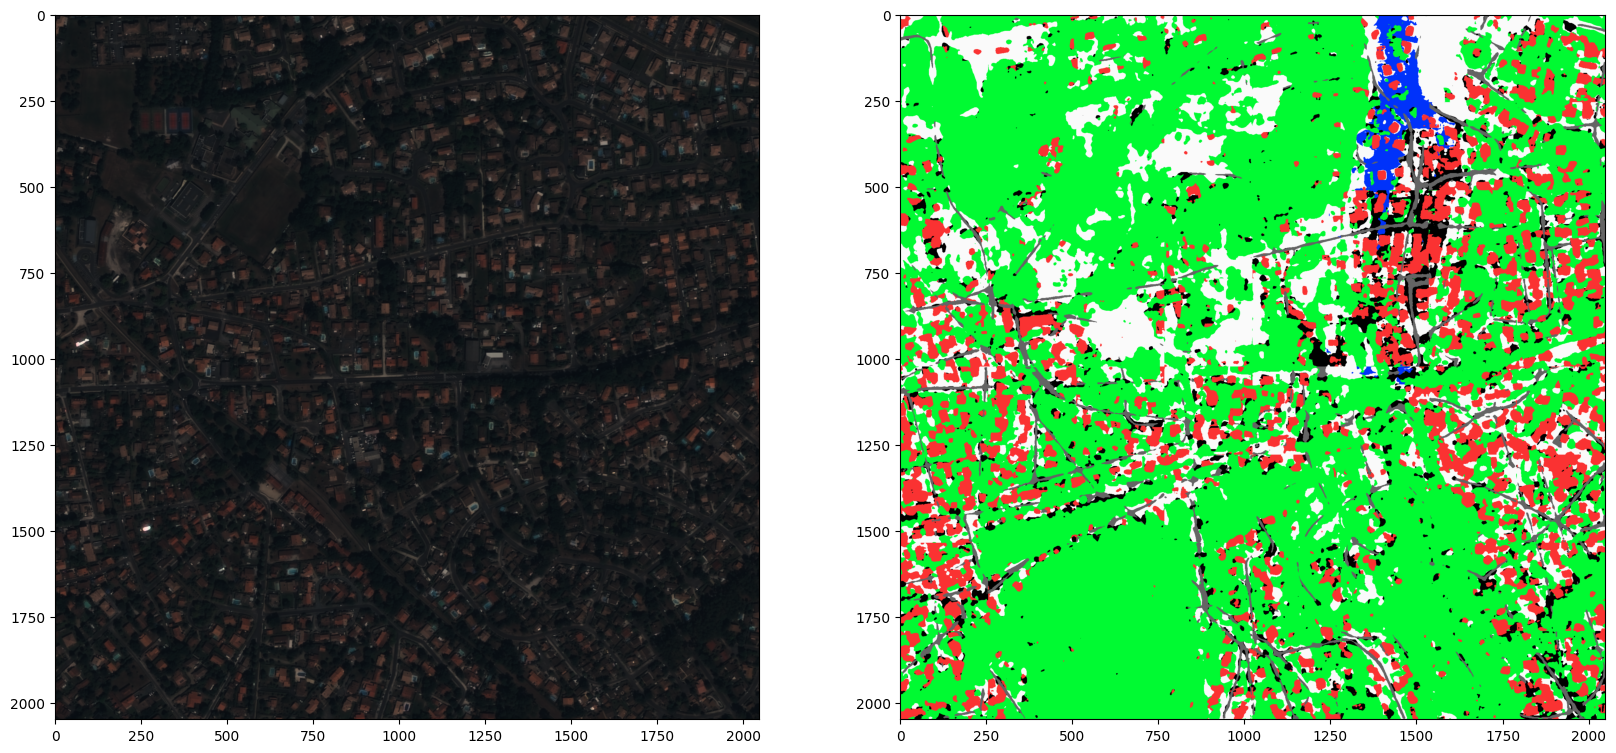

In [40]:
%matplotlib inline
img = raster_file.read().transpose(1,2,0)[...,:3]
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(img)
ax2 = fig.add_subplot(122)
ax2.imshow(labels_to_rgb(pred))